In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First load in neural network

In [2]:
model_numpy=np.load("Neural/neural_model.npz")
w_array_0=np.matrix(model_numpy["w_array_0"])
b_array_0=np.matrix(model_numpy["b_array_0"])
w_array_1=np.matrix(model_numpy["w_array_1"])
b_array_1=np.matrix(model_numpy["b_array_1"])

In [3]:
# Input params:
xdata = np.load('../GibbsChem/Network Training Data/APOGEE Training Data.npz')
norm_params=xdata['norm_grid']

In [4]:
# Normalization Parameters
norm_means=xdata['means']
norm_widths=xdata['full_widths']

In [5]:
def neural_net(norm_params):
    if isinstance(norm_params[0],np.ndarray):
        n_stars=len(norm_params)
        layer1=np.matmul(norm_params,w_array_0.T)+np.matmul(np.matrix(np.ones(n_stars)).T,b_array_0)
        layer2=np.matmul(np.tanh(layer1),w_array_1.T)+np.matmul(np.matrix(np.ones(n_stars)).T,b_array_1)
    else: 
        layer1=np.dot(norm_params,w_array_0.T)+b_array_0
        layer2=np.dot(np.tanh(layer1),w_array_1.T)+b_array_1
    return(layer2)

### Read in APOGEE Data and Priors
- NB: Ages are in ln(years) here
- Priors are from Philcox+17

*This step is slightly unnecessary but could be useful if the prior means are not the same as the normalization means*

In [12]:
n_stars = 10
apogee=np.load('../GibbsChem/APOGEE_dataset.npz')
mu_ages = apogee['ln_age'][:n_stars]
sigma_ages = apogee['ln_age_err'][:n_stars]

In [13]:
# Proto-solar data
sol_data,sol_err=np.load('Chempy/input/stars/Proto-sun.npy')
sol_els = sol_data.dtype.names
sol_ages = np.log(sol_data[-1])
sol_sigma_ages = sol_err[-1]/sol_data[-1]

In [14]:
solar_abundances=[];solar_errors=[]
for name in apogee['names']:
    for i in range(len(sol_els)):
        if name==sol_els[i]:
            solar_abundances.append(sol_data[i])
            solar_errors.append(sol_err[i])

In [15]:
APOGEE_abundances=apogee['abun'][:n_stars]
APOGEE_errors=apogee['abun_err'][:n_stars]

In [10]:
# FOR TESTING
n_stars=1
mu_ages = [np.array(sol_ages)]
sigma_ages = [np.array(sol_sigma_ages)]
APOGEE_abundances=np.matrix(solar_abundances)
APOGEE_errors=np.matrix(solar_errors)

In [16]:
unnormalized_prior_means = norm_means[:5] 
unnormalized_prior_sigmas = norm_widths[:5]

In [17]:
# Read in priors:
Lambda_prior_mu = unnormalized_prior_means[:2]-norm_means[:2]
Lambda_prior_sigma = unnormalized_prior_sigmas[:2]/norm_widths[:2]
Theta_prior_mu = unnormalized_prior_means[2:5]-norm_means[2:5]
Theta_prior_sigma = unnormalized_prior_sigmas[2:5]/norm_widths[2:5]

# Define stacked local priors
Local_prior_mu = np.vstack([np.hstack([Theta_prior_mu,mu_ages[i]]) for i in range(n_stars)])
Local_prior_sigma = np.vstack([np.hstack([Theta_prior_sigma,sigma_ages[i]]) for i in range(n_stars)])

## Define Priors and Likelihoods

In [18]:
def neg_log_prior_global(Lambda):
    # Return prior for global parameters
    tmp = (Lambda-Lambda_prior_mu)/Lambda_prior_sigma
    return 0.5*np.sum(tmp**2.)
def neg_log_prior_local(Thetas,ages):
    # Return prior for local parameters
    # input is Thetas local variables, ages of stars
    # This returns a vector of priors for each star
    all_local=np.hstack([Thetas,ages])
    tmp = (all_local-Local_prior_mu)/Local_prior_sigma
    return 0.5*np.sum(np.square(tmp),axis=1)

In [19]:
def each_star_likelihood(Lambda,Thetas,ages):
    # Return negative log likelihood for each star
    Lambda_arr = np.vstack([Lambda for _ in range(len(ages))])
    prediction = neural_net(np.hstack([Lambda_arr,Thetas,ages]))
    true_data = APOGEE_abundances
    error = APOGEE_errors
    tmp = (prediction-true_data)/error
    return 0.5*np.sum(np.square(tmp),axis=1)
def all_star_likelihood(Lambda,Thetas,ages):
    # Return negative log likelihood for many stars
    predictions=neural_net(np.hstack([Lambda,Thetas,ages]))
    true_data = APOGEE_abundances
    error = APOGEE_errors
    temp_matrix = ((predictions-true_data)/error)
    return np.sum(np.matmul(temp_matrix,temp_matrix.T))

In [20]:
def Lambda_distribution(Lambda_new,Thetas,ages):
    # Probability distribution P(Lambda|Thetas,ages)
    # Returns negative log probability
    Lambda_array = np.matmul(np.matrix(np.ones(len(Thetas))).T,np.matrix(Lambda_new))
    return all_star_likelihood(Lambda_array,Thetas,ages)+neg_log_prior_global(Lambda_new)
def Local_distribution(Thetas_new,ages_new,Lambda):
    # Probability distribution P(Theta_j,age_j|Lambda) for star j
    # Returns negative log probability
    like=each_star_likelihood(Lambda,Thetas_new,ages_new)
    prior = neg_log_prior_local(Thetas_new,ages_new)
    return like+prior 

## Construct the Gibbs Sampler

In [17]:
## PARAMETERS
N = 5000 # number of steps
burn = 0 # burn in steps
thin = 1 # thinning
seed = 1 # controls the random starting point
local_repeats = 1

Lambda_jump = 0.01*np.array([1.,1.]) # step size of Lambda
Theta_jump = 0.005*np.array([1.,1.,1.]) # step size for local variables
Age_jump = 0.005*np.array([1.])

# Jump matrices
all_Local_jump = np.vstack([np.hstack([Theta_jump,Age_jump]) for _ in range(n_stars)])  

# Initial Positions
np.random.seed(seed) # fix the random seed
initial_Lambda = Lambda_prior_mu+0.1*np.random.randn(len(Lambda_prior_mu))*Lambda_prior_sigma
initial_single_Theta = Theta_prior_mu+0.1*np.random.randn(len(Theta_prior_mu))*Theta_prior_sigma
initial_Ages = np.matrix(mu_ages+0.1*np.random.randn(n_stars)*sigma_ages).T
initial_Thetas = np.vstack([initial_single_Theta for _ in range(n_stars)])


# can we get these old likelihoods without recomputing?
 -probably just copy them from before + add new prior?

In [18]:
# Set up initial conditions
chain = np.zeros([len(Lambda_prior_mu),N+burn])
chain[:,0]=initial_Lambda
old_Lambda = initial_Lambda
old_Ages = initial_Ages
old_Thetas = initial_Thetas
mean_Ages = np.zeros_like(initial_Ages)
mean_Thetas = np.zeros_like(initial_Thetas)
accept_global = np.zeros_like(old_Lambda)
accept_local = 0

tmp_age=np.zeros([n_stars,N+burn])

# Run sampler
for n in range(1,N+burn):
    if n%500==0: print("On step %d of %d"%(n,N+burn))
    
    ## GLOBAL UPDATE
    # First update current estimate of posterior:
    old_global_prob = Lambda_distribution(old_Lambda,old_Thetas,old_Ages)
    
    for l in range(len(old_Lambda)):
        # Draw a new position for the lth component of lambda
        new_Lambda=old_Lambda
        new_Lambda[l]=old_Lambda[l]+np.random.normal(scale=Lambda_jump[l])
        # Compute new likelihood
        new_global_prob = Lambda_distribution(new_Lambda,old_Thetas,old_Ages)
        # Now accept via a Metropolis step:
        if np.random.uniform()<np.exp(old_global_prob-new_global_prob):
            # Update current values
            old_global_prob=new_global_prob
            old_Lambda=new_Lambda
            if n>burn:
                accept_global[l]+=1
        chain[:,n]=old_Lambda
        
    ## LOCAL UPDATE
    for r in range(local_repeats):
        # First recompute old local probability with current global parameters
        old_local_probs = Local_distribution(old_Thetas,old_Ages,old_Lambda)
        # Draw a new position for all stars at once:
        all_star_jitter=np.random.normal(scale=all_Local_jump)
        new_Thetas = old_Thetas+all_star_jitter[:,1:]
        new_Ages = old_Ages+np.matrix(all_star_jitter[:,0]).T
        # Compute new likelihood for each star
        new_local_probs = Local_distribution(new_Thetas,new_Ages,old_Lambda)
        # Now accept via a Metropolis step:
        random_variable = np.asmatrix(np.random.uniform(size=n_stars)).T
        accept_prob = np.exp(old_local_probs-new_local_probs)
        change_indices = np.where(random_variable<accept_prob)[0]
        if n>burn:
            accept_local+=len(change_indices)
        # Now accept the steps for the relevant stars, keeping others constant:
        old_local_probs[change_indices]=new_local_probs[change_indices]
        old_Thetas[change_indices]=new_Thetas[change_indices]
        old_Ages[change_indices]=new_Ages[change_indices]

    ## Update estimates of mean ages and thetas:
    if n>burn:
        mean_Ages+=old_Ages
        mean_Thetas+=old_Thetas
    tmp_age[:,n]=old_Ages.ravel()
        
# Now remove burn-in phase:
output_chain = chain[:,burn::thin]
# Compute averages
mean_Ages/=N
mean_Thetas/=N
# Compute acceptance fraction
accept_global=np.asarray(accept_global,dtype=float)/N
accept_local=float(accept_local)/(n_stars*local_repeats*N)

print("Global Acceptance Fraction: Lambda1: %.1f, Lambda2: %.1f"%(100.*accept_global[0],100.*accept_global[1]))
print("Local Acceptance Fraction %.1f"%(100.*accept_local))

On step 500 of 5000
On step 1000 of 5000
On step 1500 of 5000
On step 2000 of 5000
On step 2500 of 5000
On step 3000 of 5000
On step 3500 of 5000
On step 4000 of 5000
On step 4500 of 5000
Global Acceptance Fraction: Lambda1: 85.1, Lambda2: 80.4
Local Acceptance Fraction 46.0


Now reconstruct unnormalized posterior values:

In [19]:
alpha_imf=output_chain[0,:]*norm_widths[0]+norm_means[0]
log10_N1a=output_chain[1,:]*norm_widths[1]+norm_means[1]

In [20]:
mean_log10_SFE = mean_Thetas[:,0]*norm_widths[2]+norm_means[2]
mean_log10_SFR_peak = mean_Thetas[:,1]*norm_widths[3]+norm_means[3]
mean_x_out = mean_Thetas[:,2]*norm_widths[4]+norm_means[4]
mean_log_ages = mean_Ages

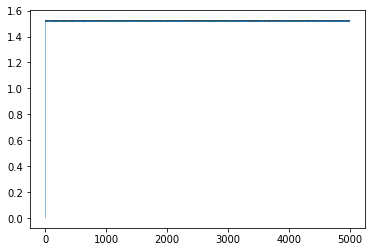

In [21]:
for i in range(len(tmp_age)):
    plt.plot(tmp_age[i,:],lw=0.5)
    plt.hlines(mu_ages[i],0,len(tmp_age[i,:]))

Text(0.5,1,'Mean Age Estimates')

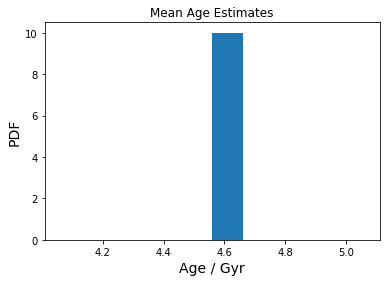

In [22]:
plt.hist(np.exp(mean_log_ages),bins=10,density=True);FS=14
plt.ylabel('PDF',fontsize=FS);
plt.xlabel('Age / Gyr',fontsize=FS);
plt.title('Mean Age Estimates')

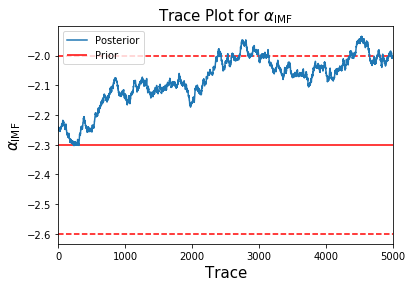

In [23]:
plt.plot(alpha_imf,label='Posterior');FS=15
plt.hlines(norm_means[0],0,len(alpha_imf),color='r',label='Prior')
plt.hlines(norm_means[0]-norm_widths[0],0,len(alpha_imf),color='r',linestyles='--')
plt.hlines(norm_means[0]+norm_widths[0],0,len(alpha_imf),color='r',linestyles='--')
plt.xlim([0,len(alpha_imf)]);plt.legend()
plt.ylabel(r'$\alpha_\mathrm{IMF}$',fontsize=FS)
plt.xlabel(r'Trace',fontsize=FS);
plt.title(r'Trace Plot for $\alpha_\mathrm{IMF}$',fontsize=FS);

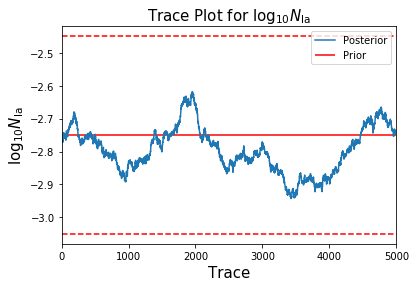

In [24]:
plt.plot(log10_N1a,label='Posterior');FS=15
plt.hlines(norm_means[1],0,len(log10_N1a),color='r',label='Prior')
plt.hlines(norm_means[1]-norm_widths[1],0,len(log10_N1a),color='r',linestyles='--')
plt.hlines(norm_means[1]+norm_widths[1],0,len(log10_N1a),color='r',linestyles='--')
plt.xlim([0,len(log10_N1a)]);plt.legend()
plt.ylabel(r'$\log_{10}N_\mathrm{Ia}$',fontsize=FS)
plt.xlabel(r'Trace',fontsize=FS);
plt.title(r'Trace Plot for $\log_{10}N_\mathrm{Ia}$',fontsize=FS);

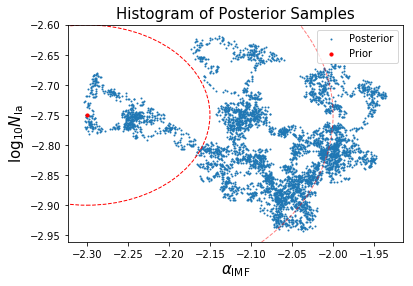

In [25]:
prior_ellipse=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],norm_widths[0],norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--')
prior_ellipse_2=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],2*norm_widths[0],2*norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--',alpha=0.5)

plt.scatter(alpha_imf,log10_N1a,s=1,label='Posterior')
plt.scatter(norm_means[0],norm_means[1],label='Prior',c='r',s=10)
plt.ylabel(r'$\log_{10}N_\mathrm{Ia}$',fontsize=FS);
plt.legend();
plt.xlabel(r'$\alpha_\mathrm{IMF}$',fontsize=FS)
plt.title(r'Histogram of Posterior Samples',fontsize=FS);
ax=plt.gca()
ax.add_patch(prior_ellipse)
ax=plt.gca()
ax.add_patch(prior_ellipse_2);

### Testing Walkers

In [34]:
# Set up initial conditions
chain = np.zeros([len(Lambda_prior_mu),N+burn])
chain[:,0]=initial_Lambda
old_Lambda = initial_Lambda
old_Ages = initial_Ages
old_Thetas = initial_Thetas
mean_Ages = np.zeros_like(initial_Ages)
mean_Thetas = np.zeros_like(initial_Thetas)
accept_global = np.zeros_like(old_Lambda)
accept_local = 0

tmp_age=np.zeros([n_stars,N+burn])

# Run sampler
for n in range(1,N+burn):
    if n%500==0: print("On step %d of %d"%(n,N+burn))
    
    ## GLOBAL UPDATE
    # First update current estimate of posterior:
    old_global_prob = Lambda_distribution(old_Lambda,old_Thetas,old_Ages)
    
    for l in range(len(old_Lambda)):
        # Draw a new position for the lth component of lambda
        new_Lambda=old_Lambda
        new_Lambda[l]=old_Lambda[l]+np.random.normal(scale=Lambda_jump[l])
        # Compute new likelihood
        new_global_prob = Lambda_distribution(new_Lambda,old_Thetas,old_Ages)
        # Now accept via a Metropolis step:
        if np.random.uniform()<np.exp(old_global_prob-new_global_prob):
            # Update current values
            old_global_prob=new_global_prob
            old_Lambda=new_Lambda
            if n>burn:
                accept_global[l]+=1
        chain[:,n]=old_Lambda
        

        

On step 500 of 5100
On step 1000 of 5100
On step 1500 of 5100
On step 2000 of 5100
On step 2500 of 5100
On step 3000 of 5100
On step 3500 of 5100
On step 4000 of 5100
On step 4500 of 5100
On step 5000 of 5100


In [137]:
n_walk=16
a = 5.; # sampler proposal distribution
n_dim=len(old_Lambda); # spatial dimension
steps=5000
burn=100
local_repeats=1
old_Lambda=initial_Lambda
old_Thetas=initial_Thetas
old_Ages=initial_Ages
mean_Ages = np.zeros_like(initial_Ages)
mean_Thetas = np.zeros_like(initial_Thetas)

current_walkers = [Lambda_prior_mu+0.1*np.random.randn(2)*Lambda_prior_sigma for _ in range(n_walk)]
old_prob = [Lambda_distribution(current_walkers[i],old_Thetas,old_Ages) for i in range(n_walk)]
accept_global=0
chain_walkers=np.zeros([n_dim,(burn+steps)*n_walk])
Theta_jump = 0.005*np.array([1.,1.,1.]) # step size for local variables
Age_jump = 0.005*np.array([1.])
all_Local_jump = np.vstack([np.hstack([Theta_jump,Age_jump]) for _ in range(n_stars)])  


for i in range(n_walk):
    chain_walkers[:,i]=current_walkers[i]

for m in range(1,steps+burn):
    if m%1000==0:
        print("Computing step %d of %d"%(m,steps+burn))
    for k in range(n_walk):
        j = np.random.randint(n_walk)
        while j==k:
            # Need different index
            j=np.random.randint(n_walk)
        # Define proposal
        u=np.random.uniform()
        Z = 1./a*pow(u*(a-1.)+1.,2.)
        proposed_walker = current_walkers[j]+Z*(current_walkers[k]-current_walkers[j])
        # Define current and old probability
        old_prob = Lambda_distribution(current_walkers[k],old_Thetas,old_Ages)
        new_prob = Lambda_distribution(proposed_walker,old_Thetas,old_Ages)
        # Now accept with some probability
        rand = np.random.uniform()
        if rand<(pow(Z,n_dim-1.)*np.exp(old_prob-new_prob)):
            current_walkers[k]=proposed_walker
            if m>burn:
                accept_global+=1
        # Now update the chain
        chain_walkers[:,m*n_walk+k]=current_walkers[k]

    ## LOCAL UPDATE
    for r in range(local_repeats):
        # First recompute old local probability with current global parameters
        # Take global parameters from the final current walker
        old_local_probs = Local_distribution(old_Thetas,old_Ages,current_walkers[-1])
        # Draw a new position for all stars at once:
        all_star_jitter=np.random.normal(scale=all_Local_jump)
        new_Thetas = old_Thetas+all_star_jitter[:,1:]
        new_Ages = old_Ages+np.matrix(all_star_jitter[:,0]).T
        # Compute new likelihood for each star
        new_local_probs = Local_distribution(new_Thetas,new_Ages,current_walkers[-1])
        # Now accept via a Metropolis step:
        random_variable = np.asmatrix(np.random.uniform(size=n_stars)).T
        accept_prob = np.exp(old_local_probs-new_local_probs)
        change_indices = np.where(random_variable<accept_prob)[0]
        if m>burn:
            accept_local+=len(change_indices)
        # Now accept the steps for the relevant stars, keeping others constant:
        old_local_probs[change_indices]=new_local_probs[change_indices]
        old_Thetas[change_indices]=new_Thetas[change_indices]
        old_Ages[change_indices]=new_Ages[change_indices]

    ## Update estimates of mean ages and thetas:
    if n>burn:
        mean_Ages+=old_Ages
        mean_Thetas+=old_Thetas
    tmp_age[:,n]=old_Ages.ravel()
        
# Compute averages
mean_Ages/=float(steps)
mean_Thetas/=float(steps)
# Compute acceptance fraction
accept_global=np.asarray(accept_global,dtype=float)/float(steps)
accept_local=float(accept_local)/(n_stars*local_repeats*steps)

print("Global Acceptance Fraction: %.1f"%(accept_global))
print("Local Acceptance Fraction %.1f"%(accept_local))
    
    
# Now output the chain
output_chain = chain_walkers[:,burn*n_walk:]
        
print("Mean acceptance rate: %.2f" %(float(accept)/(steps*n_walk)))

Computing step 1000 of 5100
Computing step 2000 of 5100
Computing step 3000 of 5100
Computing step 4000 of 5100
Computing step 5000 of 5100
Global Acceptance Fraction: 7.0
Local Acceptance Fraction 0.4
Mean acceptance rate: 0.00


### Now include parallelization via DFM

In [ ]:
## PARAMETERS
n_walk=16
a = 4.; # sampler proposal distribution
n_dim=len(old_Lambda); # spatial dimension
steps=5000
burn=500
local_repeats=1
seed = 1

np.random.seed(seed)
Theta_jump = 0.0005*np.array([1.,1.,1.]) # step size for local variables
Age_jump = 0.0005*np.array([1.])
all_Local_jump = np.vstack([np.hstack([Theta_jump,Age_jump]) for _ in range(n_stars)])  

# Initialization: 
old_Lambda=initial_Lambda
old_Thetas=initial_Thetas
old_Ages=initial_Ages
current_walkers = np.asarray([list(Lambda_prior_mu+0.1*np.random.randn(2)*Lambda_prior_sigma) for _ in range(n_walk)])
old_prob = np.asarray([Lambda_distribution(current_walkers[i],old_Thetas,old_Ages) for i in range(n_walk)])
accept=0
tmp_theta=np.zeros([len(Theta_jump),n_stars,steps+burn])
split_walk=n_walk/2 # for convenience
chain_walkers=np.zeros([n_dim,(burn+steps)*n_walk])
for i in range(n_walk):
    chain_walkers[:,i]=current_walkers[i]

for m in range(1,steps+burn):
    if m%500==0:
        print("Step %d of %d complete" %(m,steps+burn))
    for i in range(2): # Split the ensemble into two sets
        # Update walkers in parallel:
        k_indices=range(split_walk*i,split_walk*(i+1))
        # Pick random walker indices from the other half of the ensemble
        if i==0:
            j_indices = list(np.random.randint(split_walk,2*split_walk,split_walk))
        if i==1:
            j_indices = list(np.random.randint(0,split_walk,split_walk))
        # Propose a new walker
        u=np.random.uniform(size=split_walk)
        Z = np.matrix(1./a*pow(u*(a-1.)+1.,2.))
        ZZ = np.matmul(Z.T,np.matrix(np.ones(2)))
        proposed_walkers = current_walkers[j_indices]+np.multiply(ZZ,(current_walkers[k_indices]-current_walkers[j_indices]))
        # Define new probability
        
        ## TO DO: PARALLELIZE THIS:
        new_prob = np.asarray([Lambda_distribution(np.asarray(proposed_walkers[kk]),old_Thetas,old_Ages) for kk in range(split_walk)])
        
        # Now accept or reject walkers:
        rand = np.asmatrix(np.random.uniform(size=split_walk))
        tmp=np.multiply(np.power(Z,n_dim-1.),np.matrix(np.exp(old_prob[k_indices]-new_prob)))
        accept_indices = np.where(rand<tmp)[1]
        # Update probability and walkers:
        current_walkers[split_walk*i+np.asarray(accept_indices)]=proposed_walkers[accept_indices]
        old_prob[split_walk*i+np.asarray(accept_indices)]=new_prob[accept_indices]
        accept+=len(accept_indices)
        # Update chain:
        for k in k_indices:
            chain_walkers[:,m*n_walk+k]=current_walkers[k]
                   
    ## LOCAL UPDATE
    for r in range(local_repeats):
        # First recompute old local probability with current global parameters
        # Take global parameters from the final current walker
        old_local_probs = Local_distribution(old_Thetas,old_Ages,current_walkers[-1])
        # Draw a new position for all stars at once:
        all_star_jitter=np.random.normal(scale=all_Local_jump)
        new_Thetas = old_Thetas+all_star_jitter[:,1:]
        new_Ages = old_Ages+np.matrix(all_star_jitter[:,0]).T
        # Compute new likelihood for each star
        new_local_probs = Local_distribution(new_Thetas,new_Ages,current_walkers[-1])
        # Now accept via a Metropolis step:
        random_variable = np.asmatrix(np.random.uniform(size=n_stars)).T
        accept_prob = np.exp(old_local_probs-new_local_probs)
        change_indices = np.where(random_variable<accept_prob)[0]
        if m>burn:
            accept_local+=len(change_indices)
        # Now accept the steps for the relevant stars, keeping others constant:
        old_local_probs[change_indices]=new_local_probs[change_indices]
        old_Thetas[change_indices]=new_Thetas[change_indices]
        old_Ages[change_indices]=new_Ages[change_indices]

        ## Update estimates of mean ages and thetas:
        if m>burn:
            mean_Ages+=old_Ages
            mean_Thetas+=old_Thetas
    if m>burn:
        for star_index in range(len(new_Ages)):
            tmp_theta[:,star_index,m]=old_Thetas[star_index,:]
        
# Compute averages
mean_Ages/=float(steps)
mean_Thetas/=float(steps)
# Compute acceptance fraction
accept_global=np.asarray(accept_global,dtype=float)/float(steps)
accept_local=float(accept_local)/(n_stars*local_repeats*steps)

print("Local Acceptance Fraction %.1f"%(accept_local))
      
# Now output the chain
output_chain = chain_walkers[:,burn*n_walk:]
        
print("Mean acceptance rate: %.2f" %(float(accept)/(steps*n_walk)))

In [ ]:
alpha_imf=output_chain[0,:]*norm_widths[0]+norm_means[0]
log10_N1a=output_chain[1,:]*norm_widths[1]+norm_means[1]

In [ ]:
plt.plot(alpha_imf,label='Posterior');FS=15
plt.hlines(norm_means[0],0,len(alpha_imf),color='r',label='Prior')
plt.hlines(norm_means[0]-norm_widths[0],0,len(alpha_imf),color='r',linestyles='--')
plt.hlines(norm_means[0]+norm_widths[0],0,len(alpha_imf),color='r',linestyles='--')
plt.xlim([0,len(alpha_imf)]);plt.legend()
plt.ylabel(r'$\alpha_\mathrm{IMF}$',fontsize=FS)
plt.xlabel(r'Trace',fontsize=FS);
plt.title(r'Trace Plot for $\alpha_\mathrm{IMF}$',fontsize=FS);

In [ ]:
plt.plot(log10_N1a,label='Posterior');FS=15
plt.hlines(norm_means[1],0,len(log10_N1a),color='r',label='Prior')
plt.hlines(norm_means[1]-norm_widths[1],0,len(log10_N1a),color='r',linestyles='--')
plt.hlines(norm_means[1]+norm_widths[1],0,len(log10_N1a),color='r',linestyles='--')
plt.xlim([0,len(log10_N1a)]);plt.legend()
plt.xlim([20000,25000])
plt.ylabel(r'$\log_{10}N_\mathrm{Ia}$',fontsize=FS)
plt.xlabel(r'Trace',fontsize=FS);
plt.title(r'Trace Plot for $\log_{10}N_\mathrm{Ia}$',fontsize=FS);

In [ ]:
plt.plot(tmp_theta[0,0,:])

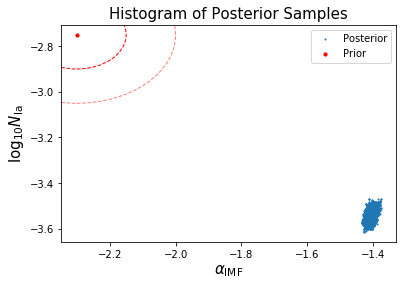

In [203]:
prior_ellipse=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],norm_widths[0],norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--')
prior_ellipse_2=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],2*norm_widths[0],2*norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--',alpha=0.5)

plt.scatter(alpha_imf,log10_N1a,s=1,label='Posterior')
plt.scatter(norm_means[0],norm_means[1],label='Prior',c='r',s=10)
plt.ylabel(r'$\log_{10}N_\mathrm{Ia}$',fontsize=FS);
plt.legend();
plt.xlabel(r'$\alpha_\mathrm{IMF}$',fontsize=FS)
plt.title(r'Histogram of Posterior Samples',fontsize=FS);
ax=plt.gca()
ax.add_patch(prior_ellipse)
ax=plt.gca()
ax.add_patch(prior_ellipse_2);